# Stokes solver for asymptotic flow

Inport away.

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 16.0)
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import fftpack
from numpy import fft
import json
from functools import partial
class Foo: pass
from chest import Chest
from slict import CachedSlict
from glopen import glopen, glopen_many

Load a frame from a real simulation.

In [2]:
name = "HighAspect/HA_viscosity_4.0E-4/HA_viscosity_4.0E-4"
arch = "alcf#dtn_mira/projects/alpha-nek/experiments"
c = Chest(path="{:s}-results".format(name), 
                       open=partial(glopen, endpoint=arch),
                       open_many = partial(glopen_many, endpoint=arch))
sc = CachedSlict(c)
c.prefetch(sc[:,'t_xy'].full_keys())
with glopen(
            "{:s}.json".format(name), mode='r',
            endpoint = arch,
            ) as f:
    p = json.load(f)

Load the governing properties from the frame.

In [3]:
L = 1./p["kmin"]
Atwood = p["atwood"]
g = p["g"]
viscosity = p["viscosity"]

Load the last midplane slice of the scalar field and manipulate it into a periodic box.

In [4]:
T_end = sc[:,'t_xy'].keys()[-1]
phi_raw = sc[T_end, 't_xy']
phi_raw = np.concatenate((phi_raw, np.flipud(phi_raw)), axis=0)
phi_raw = np.concatenate((phi_raw, np.flipud(phi_raw)), axis=0)
phi_raw = np.concatenate((phi_raw, np.fliplr(phi_raw)), axis=1)
phi_raw = np.concatenate((phi_raw, np.fliplr(phi_raw)), axis=1)
raw_shape = phi_raw.shape
nx = raw_shape[0]
ny = raw_shape[0]
phi = phi_raw[nx/8:5*nx/8, ny/8:5*ny/8]
nx = phi.shape[0]
ny = phi.shape[1]

Make sure it looks OK.

/home/maxhutch/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


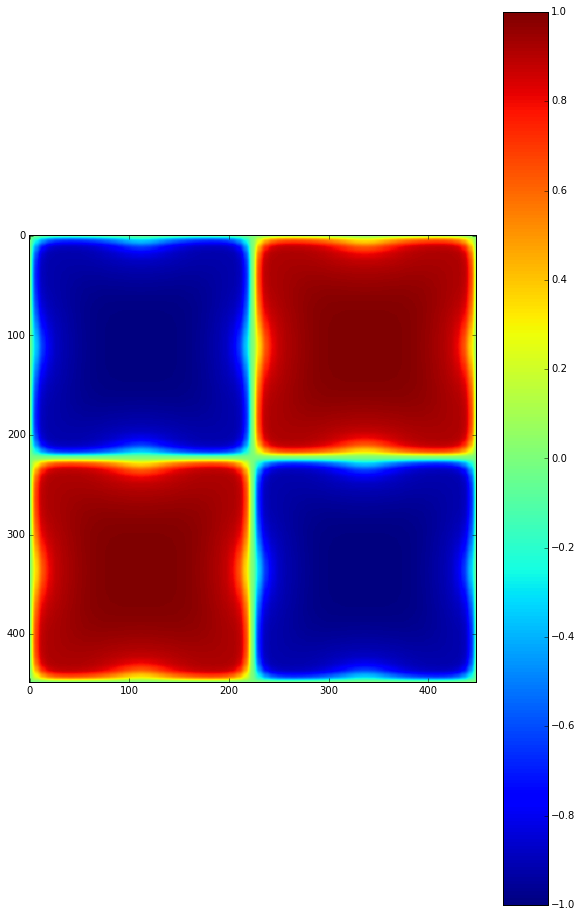

In [5]:
plt.figure()
plt.imshow(phi)
plt.colorbar();

Stokes is linear and we have periodic boundaries, so we can solve it directly using Fourier transforms and the frequency-space Green's function (which is diagonal).

In [6]:
# Setup the frequencies
dx = L / ny
X = np.tile(np.linspace(0, L, nx), (ny, 1))
Y = np.tile(np.linspace(0, L, ny), (nx, 1)).transpose()
rfreqs = fft.rfftfreq(nx, dx) * 2 * np.pi;
cfreqs = fft.fftfreq(nx, dx)* 2 * np.pi;
rones = np.ones(rfreqs.shape[0]);
cones = np.ones(cfreqs.shape[0]);

# RHS comes from the forcing
F = phi * Atwood * g / viscosity

# Transform forward
p1 = fft.rfftn(F)
# Green's function
p1 = p1 / (np.square(np.outer(cfreqs, rones)) + np.square(np.outer(cones, rfreqs)))
p1[0,0] = 0
# Transform back
w = fft.irfftn(p1)

/home/maxhutch/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide
/home/maxhutch/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


Look ok?

/home/maxhutch/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


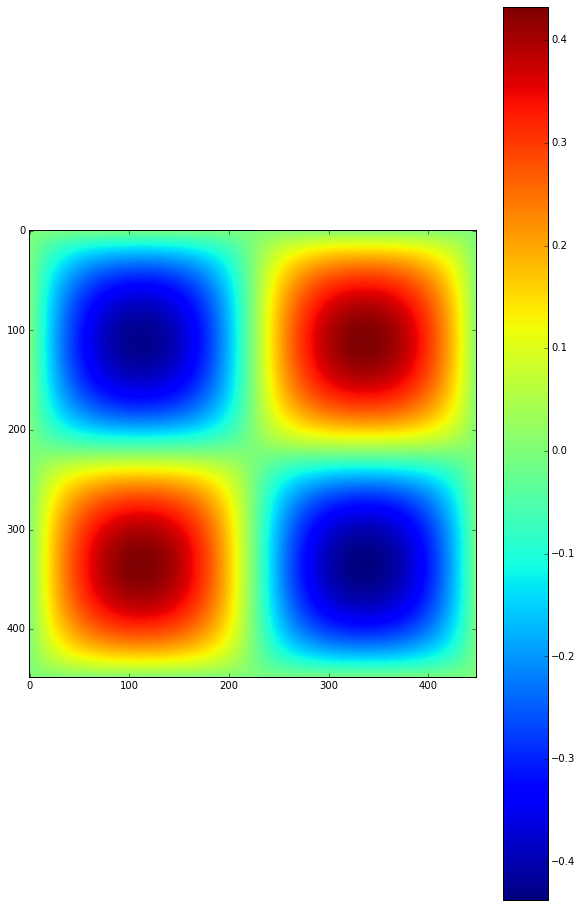

In [7]:
plt.figure()
plt.imshow(w)
plt.colorbar();

Now we want to turn this into something Darcy-Weisbach-esque.  We don't have uniform forcing, so we take an average.

In [8]:
A_tilde = np.sum(np.abs(phi))/ (nx * ny)

Rayleight-Taylor types like the Froude number, which doesn't really make sense:
$$ \text{Fr} = \frac{u}{\sqrt{A g L}} $$

In [9]:
Froude = np.sum(np.abs(w)) / np.sqrt(g * Atwood * A_tilde * L) / (nx * ny)

Instead, we normalize "the right way" using the viscosity:

In [10]:
Right = np.sum(np.abs(w)) * viscosity / (g * Atwood * A_tilde * L**2)/ (nx*ny)

Print everything out.

In [11]:
dff = 64 / 16 * 14.227
print("L={:f}, A={:f}, A_til={:f}, g={:f}, nu={:f}.  D-W is {:f}".format(
       L, Atwood, A_tilde, g, viscosity, 1./(dff*2)))
print("  Froude: {:10f} |  Right: {:10f}".format(Froude, Right))
print("  C1 = {:f} * C0 ".format(1./Right))

L=1.000000, A=0.001000, A_til=0.835020, g=9.800000, nu=0.000400.  D-W is 0.008786
  Froude:   2.233357 |  Right:   0.009875
  C1 = 101.261227 * C0 
